
# Introduction

In this series of excercises, you will learn how to work with ase databases,
and do some simple machine learning for electronic structure properties. The
driving idea is to predict complex properties of compounds from simpler
properties, under the slogan that the fastest calculation is the one you
don't have to run. We start by importing some relevant packages for
scientific python and `ase` in particular.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ase.db import connect


In the current directory, there is an `ase` database file called 'organometal.db'.
It contains information about organometallic perovskites, and the goal is to
predict properties for these. Along with the perovskite compounds, there are
also reference calculations of the elements in their standard states. We
start by connecting to the database (more info on the `ase db` module can be
found [here](https://wiki.fysik.dtu.dk/ase/ase/db/db.html#module-ase.db)),
and inspecting a single row:


In [2]:
db = connect('organometal.db')
row = next(db.select(project='organometal'))
vars(row)

{'_constraints': [],
 '_constrained_forces': None,
 '_data': b'\x08\x00\x00\x00\x00\x00\x00\x00{}',
 '_keys': ['gllbsc_disc',
  'project',
  'name',
  'symmetry',
  'gllbsc_ind_gap',
  'space_group',
  'gllbsc_dir_gap'],
 'gllbsc_disc': 1.16255167424,
 'project': 'organometal',
 'name': 'FAPbCl3',
 'symmetry': 'cubic',
 'gllbsc_ind_gap': 3.1711144486300005,
 'space_group': 'Pm-3m',
 'gllbsc_dir_gap': 3.1711144486300005,
 'id': 1,
 'unique_id': '4308611a5838ff36b1000c1e193f309b',
 'ctime': 14.594562483135096,
 'mtime': 22.610487681495318,
 'user': 'ivca',
 'numbers': array([82, 17, 17, 17,  6,  1,  1,  1,  1,  1,  7,  7], dtype=int32),
 'positions': array([[-0.06292938,  0.02971551,  0.10378368],
        [ 2.80069557,  0.15641387,  0.06054166],
        [-0.25643367,  2.90256087, -0.16420323],
        [ 0.09866038, -0.0949907 ,  3.23839837],
        [ 3.00008247,  3.1180841 ,  2.94410401],
        [ 2.64579562,  3.9667072 ,  2.34223777],
        [ 4.54241163,  2.77073058,  1.67281093],
 


Each row of the database has some key-value pairs, which are stored explicitly, as well as some basic information which is always stored, recording how the data was calculated. Can you identify what each of the keys below refers to?

calculator:
calculator_parameters:
cell:
ctime:
energy:
gllbsc_dir_gap:
gllbsc_disc:
gllbsc_ind_gap:
id:
initial_magmoms:
mtime:
name:
numbers:
pbc:
positions:
project:
space_group:
symmetry:
unique_id:
user:



Each row also has a `toatoms()` method, which lets us extract an `ase.Atoms` object from the row.


In [3]:
from ase.visualize import view
view(row.toatoms())


When doing any kind of data analysis, the first step is always to become familiar with the data in question, on a basic level. The `select()` method of the database applies a query to the database and returns an iterator of all the rows matching that query. To select all rows with a user of `einstein`, we would type `db.select(user='einstein')`. To select all rows with a gllbsc direct gap greater than 0.5 eV, we would type `db.select('gllbsc_dir_gap>0.5')`.
Counting the number of hits can be be done using `db.count(key=value)` for some key-value pair.

How many rows are there in the database?
How many belong to the `organometal` _project_? And how many to the `references` _subproject_?


In [4]:
N = db.count()
om = db.count(project="organometal")
refs = db.count(subproject="references")
print(f"There are {N} entries, of which {om} are part of the `organometallic` project, and {refs} are references.")

There are 156 entries, of which 148 are part of the `organometallic` project, and 8 are references.



The structures in the database were generated from the general formula ABX,
and then varying A, B and X. X represents a combination of 3 halogen atoms,
chosen from ["Cl", "Br", "I"]. The A, B and X is encoded in value for the key
`name`, i.e. `row.name -> 'CsPbI3'`. We have also distorted some of the
structures, giving four different symmetry types for each atomic composition.

1. Try to identity the possible values of A and B.
   (Hint: A and B is labeled with two characters `row.name`,
   i.e `A='Cs'` and `B='Pb'` in `'CsPbI3'`)

2. Can you identify the four different symmetry classes?

3. By making all possible combinations of both A, B, X, and symmetries, how
   many structures could be generated in total? And how many unique are there,
   i.e. without considering the different symmetries?


In [5]:
from math import comb
# general formula ABX
Xs = {"Cl", "Br", "I"}
As = set()
Bs = set()
sym_classes = set()
for row in db.select(project="organometal"):
    As.update((row.name[:2],))
    Bs.update((row.name[2:4],))
    sym_classes.update((row.symmetry,))

print(f"The A atoms are one of {As}. The B atoms are one of {Bs}. The used symmetry classes are {sym_classes}.")
n_Xs = len(Xs)
n_uniq = len(As) * len(Bs) * comb(2 * n_Xs - 1, n_Xs)
print(f"There are {n_uniq} unique compounds, and {len(sym_classes)*n_uniq} structures, when symmetry is considered.")

The A atoms are one of {'FA', 'MA', 'Cs'}. The B atoms are one of {'Pb', 'Sn'}. The used symmetry classes are {'orthorhombic_2', 'tetragonal', 'orthorhombic_1', 'cubic'}.
There are 60 unique compounds, and 240 structures, when symmetry is considered.


In [6]:
comb(2 * n_Xs - 1, n_Xs)

10

In [7]:
n_Xs

3


As you can see from the exercise above, two organic molecules (methylammonium MA, formula CH$_6$N and formamidinium FA, formula CH$_5$N$_2$) can be used instead of Cs as cations in the inorganic perovskite template. View the structure of MA and FA from the reference subproject in the database.


In [8]:
view(db.get(element="MA").toatoms())
view(db.get(element="FA").toatoms())


Two good ideas are to plot distributions of interesting quantities, and to calculate some summary statistics of numeric quantities, such as the mean and the variance.


Mean of `gllbsc_disc` = 0.9155
Variance of `gllbsc_disc` = 0.1076


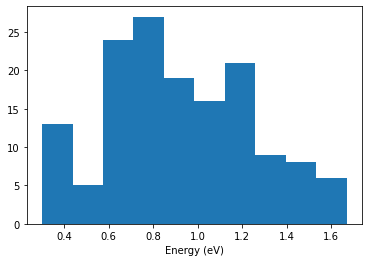

In [9]:
organometal_rows = [x for x in db.select(project='organometal')]
discs = [x.gllbsc_disc for x in organometal_rows]
print(f"Mean of `gllbsc_disc` = {np.mean(discs):.4f}")
print(f"Variance of `gllbsc_disc` = {np.var(discs):.4f}")
plt.hist(discs)
plt.xlabel('Energy (eV)')
plt.show()


Make a histogram for each of the numeric quantities in the database, and calculate the mean and variance of these quantities. You can also make scatter plots of one quantitity against another by using the `scatter` method of pyplot, `plt.scatter()`. How do these distributions vary with the `symmetry` keyword of the database?


In [10]:
numeric_quantities = ["energy", "gllbsc_disc", "gllbsc_dir_gap", "gllbsc_ind_gap"]



The energy contained in each row is an energy with respect to some arbitrary reference, which was set in the original calculation. A more sensible reference is provided by the materials with `subproject == 'references'`. We can calculate the heat of formation per unit cell of the 'MAPbI3' compound as follows:


In [11]:
row = db.get(name='MAPbI3', symmetry='cubic')
en_cubic = row.energy
en_refs = {}
for row in db.select(subproject='references'):
    en_refs[row.element] = row.energy / row.natoms

E_standard = en_cubic - (8 * en_refs['MA'] + en_refs['Pb'] + 3 * en_refs['I'])
print(f'hof = {E_standard / row.natoms:.3f} eV/atom')

hof = -0.668 eV/atom


In [12]:
print(row.toatoms())

Atoms(symbols='CH5N2', pbc=True, cell=[15.0, 15.0, 15.0], calculator=SinglePointCalculator(...))



Based on this, can you calculate the difference in heat of formation per formula unit of MAPbI$_3$ in the tetragonal phase versus the cubic phase? What about the heat of formation of FASnBr$_2$Cl in the orthorhombic_1 phase versus the cubic phase of the FASnBr$_3$, and of FASnCl$_3$. (hint: tetragonal and orthorhombic phases have a unit cell larger than the cubic structure).


Mean of `energy` = -139.1946
Variance of `energy` = 7592.3967

Mean of `gllbsc_disc` = 0.9155
Variance of `gllbsc_disc` = 0.1076

Mean of `gllbsc_dir_gap` = 2.3065
Variance of `gllbsc_dir_gap` = 1.2684

Mean of `gllbsc_ind_gap` = 2.2593
Variance of `gllbsc_ind_gap` = 1.1715



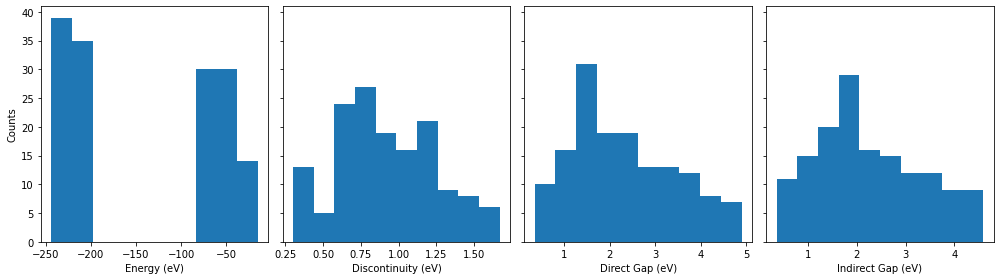

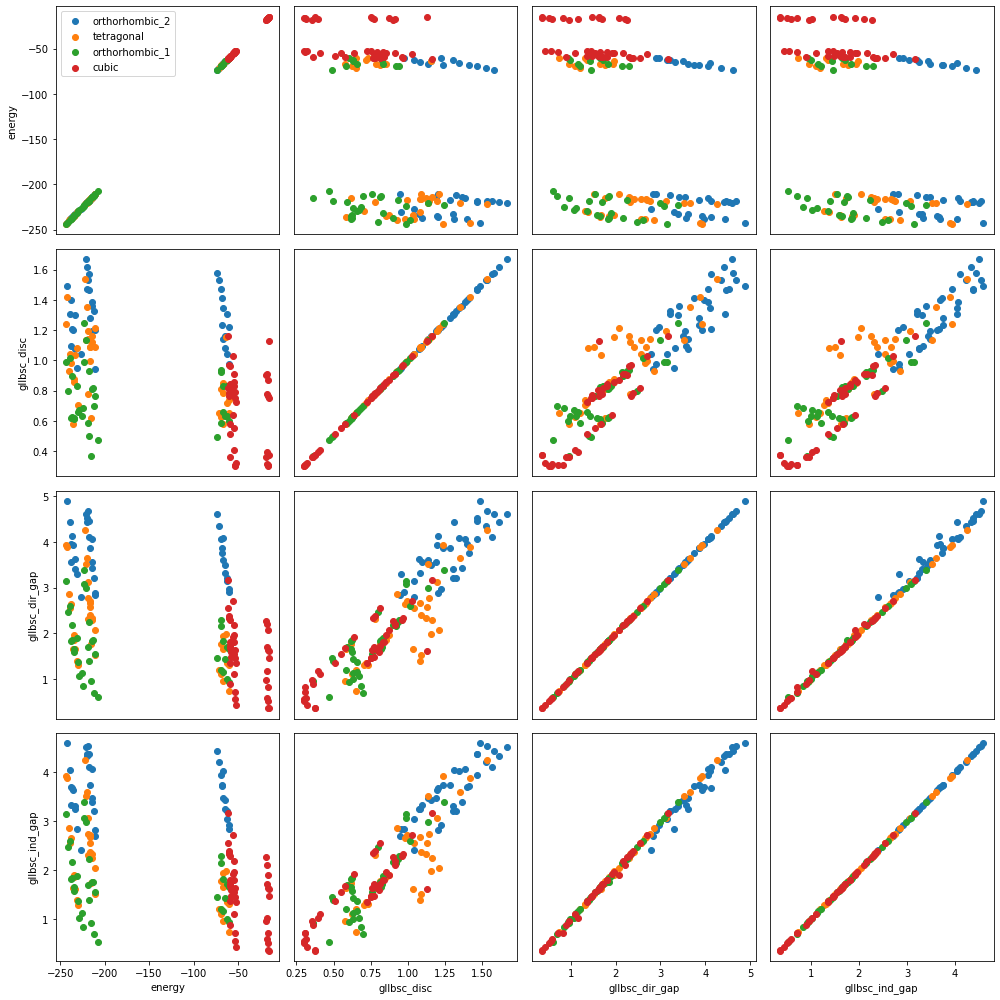

In [13]:
N = len(numeric_quantities)
labels = ["Energy (eV)", "Discontinuity (eV)", "Direct Gap (eV)", "Indirect Gap (eV)"]
all_data = list(db.select(project="organometal"))
classes = [x.symmetry for x in all_data]
y = np.array(classes)

fig, axs = plt.subplots(1, N, sharey=True, figsize=(14,4))
axs[0].set_ylabel("Counts")
for i, (colm, lab) in enumerate(zip(numeric_quantities, labels)):
    x = [r[colm] for r in all_data]
    axs[i].hist(x)
    axs[i].set_xlabel(lab)
    print(f"Mean of `{colm}` = {np.mean(x):.4f}")
    print(f"Variance of `{colm}` = {np.var(x):.4f}\n")
fig.tight_layout()
plt.show()

X = np.array([[x[c] for c in numeric_quantities] for x in all_data])
fig, axs = plt.subplots(N, N, figsize=(14,14))
for n1 in range(N):
    for n2 in range(N):
        for c in set(classes):
            ax = axs[n1, n2]
            mask = (c==y)
            ax.scatter(X[mask, n2], X[mask, n1])
            if n1 == N-1:
                ax.set_xlabel(numeric_quantities[n2])
            else:
                ax.set_xticks([])
            if n2 == 0:
                ax.set_ylabel(numeric_quantities[n1])
            else:
                ax.set_yticks([])
fig.tight_layout()
axs[0, 0].legend(list(set(classes)), loc='upper left')
plt.show()


# Machine Learning

Machine Learning is the science of getting computers to learn and act like humans do, and improve their learning over time in autonomous fashion, by feeding them data and information in the form of observations and real-world interactions. The crucial idea is that the computer should be able to improve its performance at a given task as we give it more information. A tutorial on machine learning in general can be found [here](http://scikit-learn.org/stable/tutorial/basic/tutorial.html).

In this workbook we will be carrying  out a supervised learning task, where we attempt to predict a particular (known) attribute of a given structure, based on other attributes of the structure. This can be useful if it allows us to use easy-to-calculate properties to say something about quantities which are difficult to calculate. This approach to learning, where we attempt to find a map $f$ from the attributes, $X$, of our data to some target property, $y$, is known as supervised learning. See [here](https://en.wikipedia.org/wiki/Supervised_learning) for more general information on the topic.

The two most important ingredients in the supervised learning approach are which attributes of the data we feed into the machine learning process, and which model we then apply on the data.

## Input Vectors

To start, we use a one-hot encoding of each of the different categories of data as our input vector. Later, you will be asked to see if you can find a better set of features to describe the data.


In [14]:
def calculate_input_vector(row):
    symm_vec = [0, 0, 0, 0]
    A_vec = [0, 0, 0]
    B_vec = [0, 0]
    X_vec = [0, 0, 0]  # i.e I3->[0, 3, 0], I2Cl->[1, 2, 0], Br3->[0, 0, 3]
    constant = [1,]
    symm_vec[['cubic',
              'tetragonal',
              'orthorhombic_1',
              'orthorhombic_2'].index(row.symmetry)] = 1
    A_vec[['Cs', 'FA', 'MA'].index(row.name[:2])] = 1
    B_vec[0] = 1 if 'Pb' in row.name else 0
    B_vec[1] = 1 if 'Sn' in row.name else 0

    Xs = ['Cl', 'I', 'Br']
    nhalo = sum([s in Xs for s in row.symbols])
    for i, X in enumerate(Xs):
        X_vec[i] = 3 * sum([s == X for s in row.symbols]) // nhalo

    vec = symm_vec + A_vec + B_vec + X_vec + constant
    return vec


In a one-hot encoding, assign the data into different categorical classes, and then have one feature for each class. For example, there are four different symmetries in the data, so the first four features of the input vector describe which symmetry the material lies in. A '1' in a given position indicates that the material falls into that class, while a '0' indicates that it does not.

As an example, we apply the encoding to the first few rows of the database with cubic symmetry, and show the formula and the name:


In [15]:
for row in db.select(symmetry='cubic', limit=5):
    print(f'name={row.name} formula={row.formula} symmetry={row.symmetry}')
    print(f'vec={calculate_input_vector(row)}')
    print('-'*79)

name=FAPbCl3 formula=PbCCl3H5N2 symmetry=cubic
vec=[1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 1]
-------------------------------------------------------------------------------
name=FASnIBrCl formula=SnBrCClH5IN2 symmetry=cubic
vec=[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
-------------------------------------------------------------------------------
name=CsPbI2Br formula=CsPbBrI2 symmetry=cubic
vec=[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 1]
-------------------------------------------------------------------------------
name=MAPbBr2Cl formula=PbBr2CClH6N symmetry=cubic
vec=[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 1]
-------------------------------------------------------------------------------
name=MAPbI2Br formula=PbBrCH6I2N symmetry=cubic
vec=[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1]
-------------------------------------------------------------------------------



We see that as expected, the row has a '1' in the first position, indicating that it has a cubic symmetry.

We are now ready to generate the input matrix $X$ that we will use in the machine learning process. At the same time we extract the indirect band gap as the target vector, $y$.


In [16]:
X = []
y = []
for row in db.select('project'):
    X.append(calculate_input_vector(row))
    y.append(row.gllbsc_ind_gap)

X = np.array(X)
y = np.array(y).reshape(-1, 1)
print('X.shape = ', np.shape(X))
print('Y.shape =', np.shape(y))

X.shape =  (148, 13)
Y.shape = (148, 1)



## Modelling

With the input and output in place, we are ready to do the initial machine
learning. All supervised machine learning processes do the following, in a
generalized sense:

- Select a general functional form for the model, parametrized in
  a suitable way.

- Find a loss function to evaluate the performance of a given set
  of parameters.

- Optimize the parameters of the model to minimize the loss.

All the hard work is usually in the last step, since for complex models the
relationship between the parameters and the loss function can be very
difficult. However, for simpler models, we can sometimes find a closed form
for the loss function.

The very simplest class of machine learning models are just generalized
linear models, where the target, $y$, is assumed to be a linear function of
the input variables. You can read more about them
[here](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares). For a
linear function, we guess a functional form $f(\mathbf{x}) = \sum_n w_n x_n = \mathbf w \cdot \mathbf x$, and seek to optimize the weight vector, $\mathbf w$.

If we choose the loss function
$$ L = \sum_i (f(\mathbf{x}_i) - y_i))^2 = \sum_{i} \left(\sum_{n}w_i x_{in} - y_i\right)^2 $$
, we will recover ordinary least squares regression. In matrix terms, the loss corresponds to the norm $ L = \left\| \mathbf{y} - \mathbf{X} \mathbf{w} \right\|^2$.
The loss is minimal when the derivative with respect to the weight vector is zero. A bit of
rearranging gives that this is true when
$$ \mathbf w = (\mathbf{X}^T\mathbf{X}) ^ {-1} \mathbf{X}^T \mathbf{y} $$

Here $\mathbf w$ is an (n_features, 1) weight vector that we are trying to
find, $\mathbf{X}$ is an (n_samples , n_features) matrix of our observed
inputs and $\mathbf y$ is the (n_samples, 1) output vector that we are trying
to predict.

Write a function `fit`, which takes as input a matrix $\mathbf X$, and a
target vector $\mathbf y$, and performs this linear regression, returning the
list of weights and an estimate of the loss for this list of weights.

Hint: useful functions are `np.dot()` and `np.linalg.inv()`, which calculate
the dot product and inverse, respectively, of their arguments.


In [17]:
def fit(X, y):
    """
    code goes here
    """
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    loss = np.linalg.norm(y - X @ w)**2
    return w, loss



You can test your code on the following toy input - hopefully the weight vector you find is close to [1, 2, 3, 4, 5]


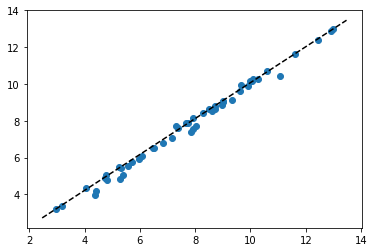

[[0.95643389]
 [1.89067199]
 [3.17229759]
 [3.84789342]
 [5.2316627 ]]


In [18]:
nsamples = 50
nfeatures = 5
X_toy = np.random.rand(250).reshape(nsamples, nfeatures)
coefficients = np.arange(1, nfeatures + 1).reshape(-1, 1)
noise = np.random.normal(scale=0.2, size=nsamples).reshape(-1, 1)
y_toy = np.dot(X_toy, coefficients) + noise
w, loss = fit(X_toy, y_toy)
plt.scatter(np.dot(X_toy, w), y_toy)
plt.plot(plt.xlim(), plt.ylim(), ls='--', color='k')

plt.show()
print(w)


Once that is working, try it on the original data! (hint: you have already calculated the matrix $X$ and target vector $y$ above) Does everything work as it should?


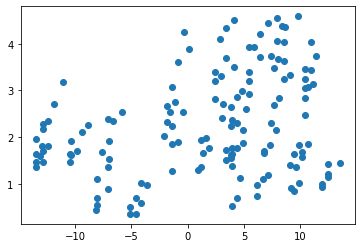

[[ 1.85938062e+15]
 [ 1.85938062e+15]
 [ 1.85938062e+15]
 [ 1.85938062e+15]
 [-1.40909438e+15]
 [-1.40909438e+15]
 [-1.40909438e+15]
 [-4.50286240e+14]
 [-4.50286240e+14]
 [ 2.92913134e-01]
 [-2.13425790e-01]
 [-2.28013101e-01]
 [-3.34610791e+00]]


In [19]:
try:
    w, loss = fit(X, y)
    plt.scatter(np.dot(X, w), y)
except np.linalg.LinAlgError:
    pass
else:
    assert abs(w).max() > 1e10

plt.show()
print(w)


One of the assumptions made in the derivation of the linear model is that the matrix $(\mathbf{X}^T\mathbf{X})$ is invertible. Unfortunately, that's not true for our case. That's because of the encoding we have chosen, which means for example that for any row, the first four columns must sum to one. The fourth column can therefore always be written as 1 - the sum of the first three.

We can alleviate this by adding a regularization term to our loss function, which penalises large weights. The new loss is can then be written as  $L = \left\| \mathbf{y} - \mathbf{X} \mathbf{w} \right\|^2 + \alpha \left\| w\right\|^2$. Luckily, there is still a closed-form solution for this, namely $\mathbf w = (\mathbf{X}^T\mathbf{X} + \alpha \mathbf{I}) ^ {-1} \mathbf{X}^T \mathbf{y}$. Modify your `fit()` function to take an extra argument $\alpha$, and apply regularization to the original problem. Does everything work now? Do the weights of your model make sense? Try few different values for $\alpha$. How does the fit changes with $\alpha$?


[[-0.63957476  0.01127152 -0.44460553  1.5270547  -0.1341592   0.26403509
   0.32444626  0.44076811  0.01280791  0.74657342  0.17220624  0.44303168
   0.45393711]] 25.073871086040892
yes e.g. first value == cubic is negative -> gives smaller bandgaps


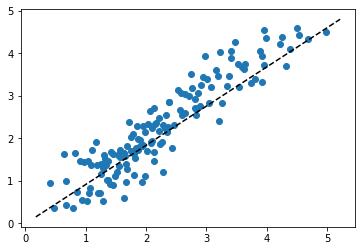

In [20]:
def fit(X, y, alpha):
    w = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    L = np.linalg.norm(y - X @ w)**2 + alpha * np.linalg.norm(w)**2
    return w, L

w, loss = fit(X, y, 1e-4)
print(w.T , loss)
print('yes e.g. first value == cubic is negative -> gives smaller bandgaps')
plt.scatter(np.dot(X, w), y)
plt.plot(plt.xlim(), plt.ylim(), ls='--', color='k')

plt.show()


We can do all the things above in scikit-learn, which is a python software package for doing many different kinds of modelling.


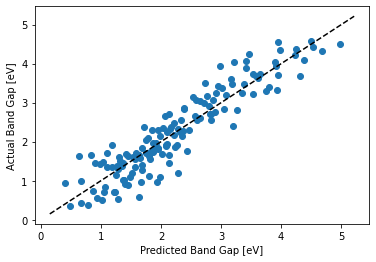

In [22]:
from sklearn import linear_model
linear = linear_model.LinearRegression()

linear.fit(X, y)
ybar = linear.predict(X)
ymax = np.array((y, ybar)).max() + 0.1
plt.scatter(ybar, y)
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()])
]
plt.plot(lims, lims, ls='--', color='k')
plt.xlabel('Predicted Band Gap [eV]')
plt.ylabel('Actual Band Gap [eV]')

# We can wrap the above in a function, to avoid typing that same code again later
def limits():
    lims = [
        np.min([plt.xlim(), plt.ylim()]),
        np.max([plt.xlim(), plt.ylim()])
    ]
    plt.plot(lims, lims, ls='--', color='k')

def make_comparison_plot(X, y, model, label):
    model.fit(X, y)
    ybar = model.predict(X)
    plt.scatter(ybar, y)
    limits()
    plt.xlabel(f'Predicted {label}')
    plt.ylabel(f'Actual {label}')


All the models in scikit-learn have a `fit` method, which expects an $X$ matrix and a $y$ vector as inputs, and then trains the model. They also have a `predict` method, which takes an $X$ matrix as input and returns the $y$ values predicted by the model. We use this to plot the true vs the predicted band gap.



We can also inspect the parameters of the model to see which elements of the input vector are important to the model:


In [23]:
print(linear.coef_)
print(linear.intercept_)

[[-0.75311323 -0.10226537 -0.55814363  1.41352223 -0.28560058  0.11259489
   0.17300569  0.21398062 -0.21398062  0.29263647 -0.28173106 -0.01090541
   0.        ]]
[2.30751404]



We see that despite the singular matrix, sklearn is able to do a linear fit, and returns sensible coefficients. Relying on this behaviour is rather brittle, and a better idea is to do as before and add a regularization parameter to the original loss function, which is done in the `linear_model.Ridge` model:


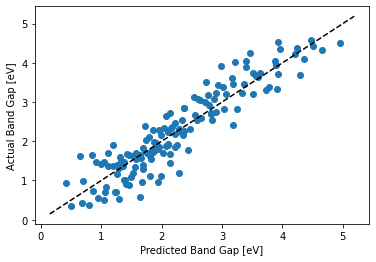

In [24]:
from sklearn import linear_model

linear_regularized = linear_model.Ridge(alpha = .5)
make_comparison_plot(X, y, linear_regularized, "Band Gap [eV]")

In [25]:
print(linear_regularized.coef_)
print(linear_regularized.intercept_)

[[-0.74340375 -0.10021133 -0.55013679  1.39375188 -0.28226543  0.11008915
   0.17217628  0.21146259 -0.21146259  0.29187829 -0.28086827 -0.01101003
   0.        ]]
[2.30716316]



From visual inspection, it seems that the regularized model performs about as well as the original linear model.

To proceed with the machine learning, we need some way of evaluating the performance of a model, which is better than visual inspection of predicted versus actual values, and an assessment of the reasonableness of model parameters. Scikit-learn provides a `score()` method for each model, which evaluates how good the fit is.


In [26]:
linear_regularized.score(X, y)

0.8552683158316907


To truly compare between models, we should ideally train on some data, and evaluate the model on a different set of data. Otherwise, we could create a perfect model just by storing all the input data, and looking up the correct answer. The way to do this is by cross-validation, where the data is randomly split into a number of buckets, and for each bucket, the model is trained on all the other data, and then tested on the data in the bucket. Since the data might have a meaningful order in the database, it is important that the assignment of the data to each bucket is done at random. This is accomplished by the `shuffle` argument to `KFold`.

This approach of evaluating the performance of a model is very general and can also be used to optimize the so-called hyperparameters of a model, such as the regularization parameter $\alpha$. Here, we will not optimize $\alpha$, but only compare the performance of the `alpha=0` and `alpha=0.5` model. The score has been chosen so that the closer it is to 1, the better.


In [27]:
from sklearn import model_selection
folds = model_selection.KFold(n_splits=2, shuffle=True, random_state=1)
print(model_selection.cross_val_score(linear_regularized, X, y, cv=folds, scoring='explained_variance'))
print(model_selection.cross_val_score(linear, X, y, cv=folds, scoring='explained_variance'))

[0.83860064 0.85240327]
[0.83748897 0.85501867]



## Modelling the heat of formation

Having looked at the band gap, we turn now to the heat of formation, which was defined further up. Try using the heat of formation as a target vector $\mathbf y$ instead of the band gap. See if it is possible to predict the heat of formation using (regularized) linear regression and the simple input vector defined above. You can use the following code to calculate the heat of formation of all the compounds in the database. Can you explain what it does?


In [28]:
en_refs = {}
for row in db.select(subproject='references'):
    en_refs[row.element] = row.energy/len(row.symbols)
HoF = []
for row in db.select(project='organometal'):
        energy = row.energy
        # how many units are in there!?
        n_units = len([True for symbol in row.symbols if symbol == 'Pb' or symbol == 'Sn'])
        energy_standard = 0
        for symbol in row.symbols:
            if symbol in ['Cs','Pb','Sn','I','Br','Cl']:
                energy_standard += en_refs[symbol]
        if 'FA' in row.name:
            energy_standard += n_units * en_refs['FA'] * 8
        if 'MA' in row.name:
            energy_standard += n_units * en_refs['MA'] * 8
        HoF.append((energy-energy_standard) / n_units)

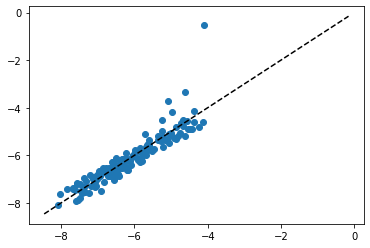

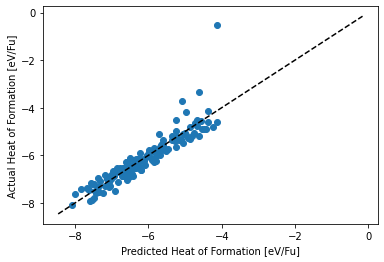

In [29]:
from sklearn import linear_model
linear_regularized = linear_model.Ridge(alpha=.5)

HoF = np.array(HoF)
w, loss = fit(X, HoF, 0.01)
ybar2 = X @ w
plt.scatter(np.dot(X, w), HoF)
limits()
plt.show()

plt.figure()
make_comparison_plot(X, HoF, linear_regularized, "Heat of Formation [eV/Fu]")


When searching for new materials, we would like to find only stable materials. These should have a negative heat of formation, and be in the most stable symmetry class of the four we are considering. The model we have just made will tell us whether a given compound has a negative heat of formation, but it won't tell us whether a different symmetry class would have a lower energy.

Predicting which symmetry class of the four is most stable for a given composition is a typical example of a classification problem: we would like to map a given composition, to which of the four symmetry classes is most stable. We start by creating the new output vector corresponding to our data. The output vector should have dimensions (n_compositions, 1), where n_compositions is the total number of different possible compositions without considering symmetries. For each composition, the output should indicate which of the symmetries in the database gives the lowest energy. An idea could be to reuse the `symmetry map` from further up.

For the input vector, we can use the same one as before, only with the first four entries (corresponding to the symmetry class) removed.

You should start by creating the target vector, which describes which symmetry is most stable for each composition:


In [30]:
# Define `X_hof` and `y_hof` in here
from collections import defaultdict
X_hof = X[:, 4:]

collection = defaultdict(list)
for vec, hof in zip(X, HoF):
    symm_vec = vec[:4].tolist().index(1)
    comp = (*vec[4:],)
    collection[comp].append((symm_vec, hof))
most_stable = {k: min(collection[k], key=lambda ls: ls[1])[0] for k in collection}

y_hof = np.array([most_stable[(*k,)] for k in X_hof])
print(y_hof.shape, X_hof.shape)

(148,) (148, 9)



Once you have that, we can start modelling this data. To try something different, we will be using a decision tree to classify the data. This can be imported as follows:


In [32]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_hof, y_hof)  # student: clf = clf.fit(?, ?)


In [33]:
# import graphviz
# feature_names = ['first_cs','first_FA','first_MA','lead','tin','chlorine','iodine','bromine','reg']
# target_names = ['cubic', 'tetragonal', 'orthorhombic_1', 'orthorhombic_2']
# dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names = feature_names,
#                                 class_names = target_names,
#                                 filled=True, rounded=True,
#                                 special_characters=True)
# graph = graphviz.Source(dot_data)
# graph


We can visualize the tree using `graphviz`. Can you explain it?


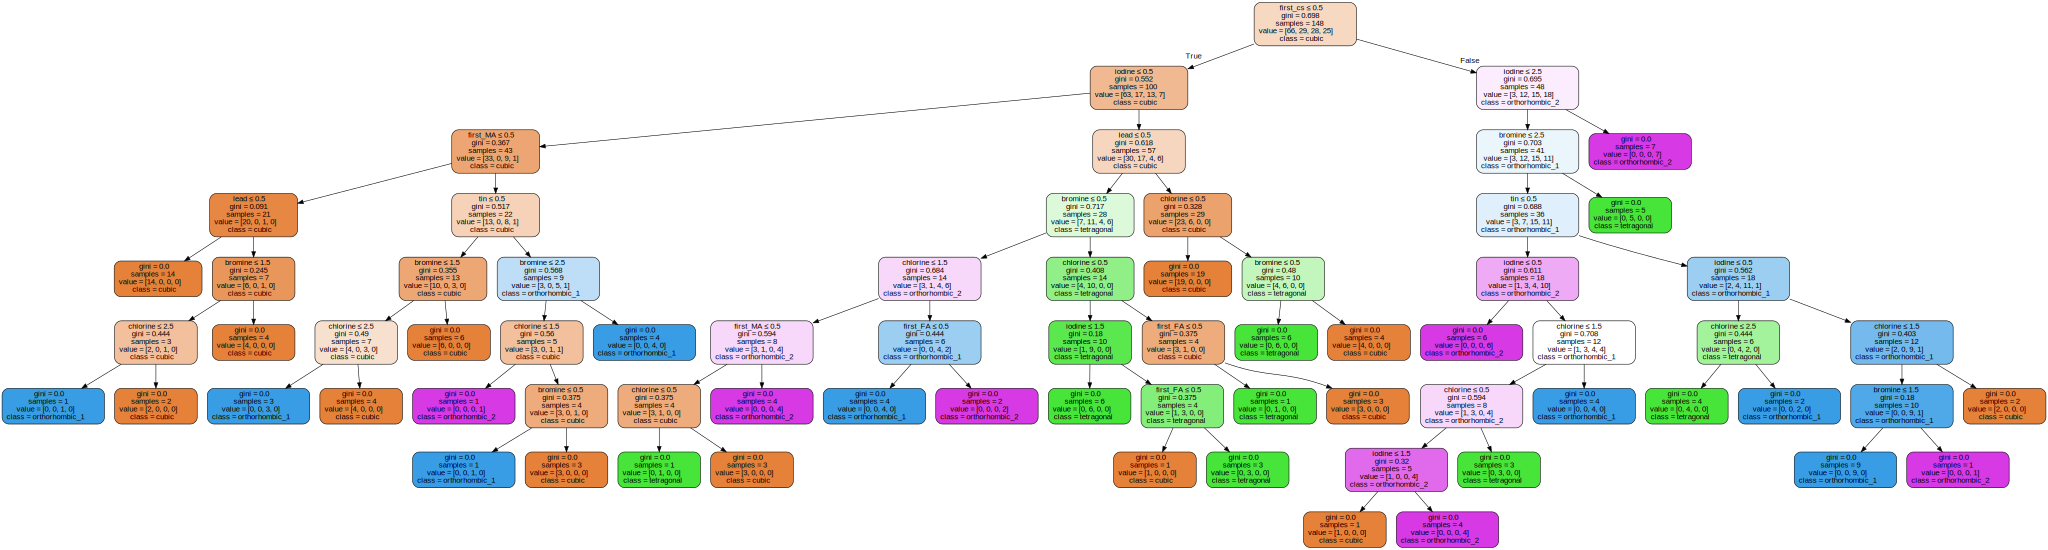

In [34]:
import graphviz
feature_names = ['first_cs','first_FA','first_MA','lead','tin','chlorine','iodine','bromine','reg']
target_names = ['cubic', 'tetragonal', 'orthorhombic_1', 'orthorhombic_2']
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names = feature_names,
                                class_names = target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph


One issue with decision trees is that it's often easy to overfit the data, by making the depth of the tree too large. To see if this is occurring, we can compute the cross-validation score of the model for different sets of maximum depths:


1 [0.56756757 0.54054054 0.40540541 0.48648649]
2 [0.59459459 0.56756757 0.45945946 0.54054054]
3 [0.62162162 0.51351351 0.54054054 0.64864865]
4 [0.62162162 0.62162162 0.54054054 0.67567568]
5 [0.67567568 0.72972973 0.62162162 0.7027027 ]
6 [0.75675676 0.89189189 0.83783784 0.78378378]
7 [0.81081081 0.89189189 0.83783784 0.86486486]
8 [0.86486486 0.89189189 0.86486486 0.83783784]
9 [0.83783784 0.81081081 0.86486486 0.86486486]


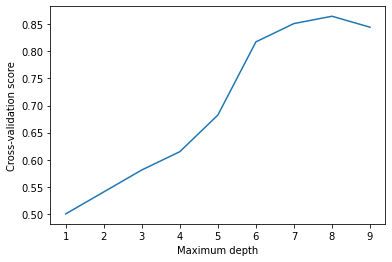

In [35]:
folds = model_selection.KFold(n_splits=4, shuffle=True, random_state=0)
scores = []
for max_depth in range(1, 10):
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    score = model_selection.cross_val_score(clf, X_hof, y_hof, cv=folds)
    print(max_depth, score)
    scores.append(score.mean())
plt.plot(range(1, 10), scores)
plt.xlabel('Maximum depth')
plt.ylabel('Cross-validation score')
plt.show()


## Improving the input vector

There is much more information we could include in the input vector, which might increase our predictive power of our model. An example could be the covalent radius of tin vs lead, or of the halogens, which will tend to increase or decrease the lattice constant of the whole crystal, and hence the energy. The covalent radii are available in `ase.data`, and can be imported as `from ase.data import covalent_radii`. Another example could be the electronegativities of the halogens, which will play a role in the character of the bonds. The mulliken electronegativities of chlorine, bromine and iodine are 8.3, 7.59 and 6.76 respectively

Start by redoing a basic examination of the data: plot the band gap and heats of formation against some of the quantities you might add, and see if there is any correlation. For the quantities that do have a correlation, try adding them to the input vector, and see which (if any) result in an improved model for either the heat of formation, the relative energetic ordering of the symmetry classes, or the band gap.


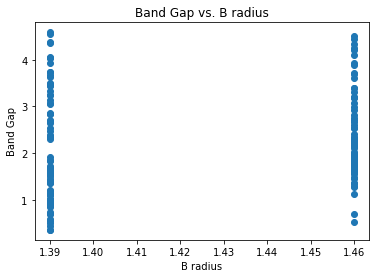

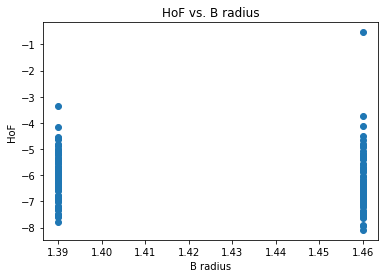

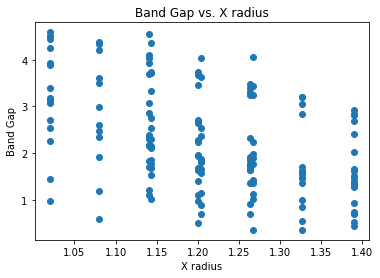

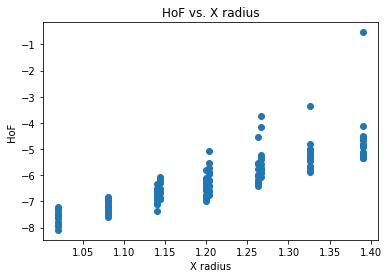

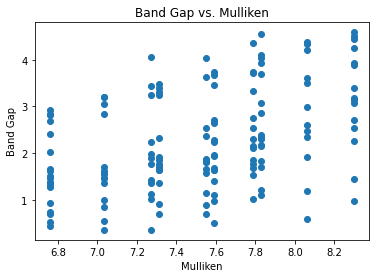

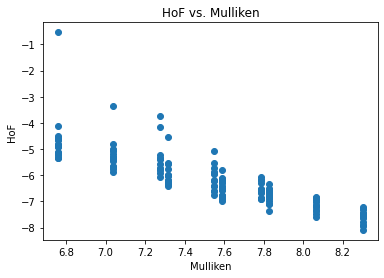

In [36]:
from ase.data import covalent_radii as c_r, atomic_numbers as num

B_radii = np.array([c_r[num['Pb']], c_r[num['Sn']]])  # Pb, Sn
X_radii = np.array([c_r[17], c_r[53], c_r[35]])  # Cl, I, Br
elec_neg = np.array([8.3, 6.76, 7.59])  # Cl, I, Br

B_r = [np.sum(r[3:5]*B_radii) for r in X_hof]
X_r = [np.mean(r[5:8]*X_radii) for r in X_hof]
eln = [np.mean(r[5:8]*elec_neg) for r in X_hof]

from itertools import product

properties = {
    "B radius": B_r,
    "X radius": X_r,
    "Mulliken": eln
}
responses = {
    "Band Gap": y,
    "HoF": HoF
}

for (prop_name, prop), (resp_name, resp) in product(properties.items(), responses.items()):
    plt.scatter(prop, resp)
    plt.title(f"{resp_name} vs. {prop_name}")
    plt.xlabel(prop_name)
    plt.ylabel(resp_name)
    plt.show()

(148, 15)


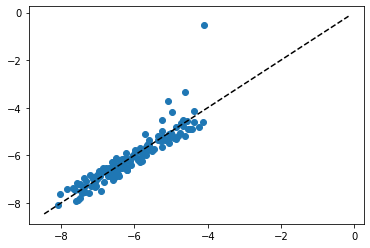

Loss with covalent:  27.61994200764555
Loss without:  31.219369567160427
yes, loss is better


In [37]:
X_add = np.hstack((X, np.array(X_r).reshape(-1, 1), np.array(eln).reshape(-1, 1)))
print(X_add.shape)

w, loss_add = fit(X_add, HoF, 0.5)
plt.scatter(np.dot(X_add, w), HoF)
limits()
plt.show()

_, loss = fit(X, HoF, 0.5)
print('Loss with covalent: ', loss_add)
print('Loss without: ', loss)
print('yes, loss is better')


## Improving the models

Most phenomena we encounter don't have nice linear relationships between inputs and outputs. We model nonlinear relationships in two different ways: we either introduce nonlinearity in our features, or in our model. The first
is known as feature engineering, and requires a good method. The second makes optimizing the parameters of our model slightly more difficult, as we can lose many of the nice properties of the linear model, such as the closed-form solution.

Here we will focus on gaussian process regression as a case study. You can read more about it [here](http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process). This lets us fit nonlinear functions and also provides a confidence interval indicating how well the machine is doing.

Similar to the `linear_regression`, we can import it from `sklearn` and create an example of the model with `model = GaussianProcessRegressor(kernel=YYY)`, where `YYY` is the kernel used. As a start, we should use a radial basis function, which is also available from `sklearn`. As usual, the model has a `fit()` and a `predict()` method, which sets the parameters of the model, and tries to predict outputs based on inputs.


In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=0.1)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X, y)
fit = model.predict(X)
model.score(X, y)

1.0


The model we have chosen is very dependent on the length scale we set for the kernel, and it is not given that the value chosen above (0.1) is a good choice. The fact that we have a score of 1.0 is an indication that we may be overfitting. The trick to selecting the best value of this parameter is again cross-validation. We can loop over different possible values of the hyperparameter to make different classes of models, and then evaluate the cross-validation score of each to see which performs best. Try this!


In [39]:
best = (None, np.zeros(3))
folds = model_selection.KFold(n_splits=3, shuffle=True, random_state=1)
for sigma in [1e-2, 1e-1, 5e-1, 1, 5e1, 1e2]:
    kernel = RBF(length_scale=sigma)
    m = GaussianProcessRegressor(kernel=kernel)
    score = model_selection.cross_val_score(m, X, y, cv=folds, scoring='explained_variance')
    new = (m, score)
    best = max(best, new, key=lambda t: t[1].mean())
    print(f"Scored {score} for length scale {sigma:e}")

best_model, best_score = best
best_model.fit(X, y).kernel_

Scored [0. 0. 0.] for length scale 1.000000e-02
Scored [0. 0. 0.] for length scale 1.000000e-01
Scored [0.92632978 0.89671123 0.86221124] for length scale 5.000000e-01
Scored [0.92632978 0.89671123 0.86221124] for length scale 1.000000e+00
Scored [0. 0. 0.] for length scale 5.000000e+01
Scored [0. 0. 0.] for length scale 1.000000e+02


/zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/zhome/fa/5/1000203270/CAMD2022/ve

RBF(length_scale=1.55)


Ideally you should find that length scales of ~1.0 perform best according to this scoring metric. In general, `scikit` has many tools for finding optimized hyperparameters for a given model - an example is [GridSearchCV](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html), which automatically goes through all possible combinations of hyperparameters, finding the best one. You should note that there is a problem with using the Cross-validation scores we compute here to evaluate the performance of a given set of hyperparameters, which is very similar to the original problem of overfitting. Can you see what it is?



# Testing and evaluating the model

Now we've reached the stage where we start actually doing electronic structure calculations!

We would like to test the models we have made by comparing the predicted quantities to calculated quantities. We are looking for a material that is not present in the database, and fulfills the following criteria:
* It has a negative heat of formation
* The cubic symmetry is the most stable for this composition class (due to computational cost of the other symmetry types)
* It has a band gap of approximately 1.5 eV

It might not be possible to find a material that fulfills all, so try to find one, where the band gap of the cubic symmetry structure is close to 1.5 eV.


In [40]:
# Determine all the materials in the database, that do not have the cubic symmetry calculated
names = set(r.name for r in db.select("symmetry!=cubic", project="organometal")) - \
        set(r.name for r in db.select(project="organometal", symmetry="cubic"))

rows = [r for n in names for r in db.select(name=n)]
new_X = np.array([calculate_input_vector(r) for r in rows])
new_X[:, :4] = [1, 0, 0, 0]

pred_bg = best_model.predict(new_X).flatten()

print(f"Material    Found Symmetry   Gap    Predicted Gap\n{'-'*50}")
for r, bg in zip(rows, pred_bg):
    print(f"{r.name: <12}{r.symmetry: <17}{r.gllbsc_ind_gap:.3f}  {bg:.3f}")


Material    Found Symmetry   Gap    Predicted Gap
--------------------------------------------------
FASnIBr2    tetragonal       1.633  0.707
FASnIBr2    orthorhombic_1   1.365  0.707
FAPbBrCl2   orthorhombic_1   2.601  2.667
CsSnI3      orthorhombic_1   0.943  0.315
CsSnI3      orthorhombic_2   2.843  0.315
CsSnI3      tetragonal       0.732  0.315
FASnICl2    orthorhombic_1   1.849  1.643
FASnICl2    orthorhombic_2   3.329  1.643
MAPbI2Cl    orthorhombic_1   1.762  1.859
MAPbI2Cl    tetragonal       2.246  1.859
FASnI3      tetragonal       1.388  1.074
MASnBr2Cl   orthorhombic_2   4.542  2.009
MASnI2Cl    orthorhombic_2   4.055  0.974
CsPbIBrCl   tetragonal       1.664  1.669
CsPbIBrCl   orthorhombic_1   1.828  1.669
CsSnBr2Cl   tetragonal       1.103  1.066
CsSnBr2Cl   orthorhombic_1   1.203  1.066
MASnIBrCl   tetragonal       2.369  1.161
FAPbI2Cl    orthorhombic_1   1.123  1.940
FAPbI2Cl    tetragonal       1.905  1.940
FASnI2Br    orthorhombic_2   2.833  0.563
FASnI2Br    ortho


Ideally there is a structure similar to it in the database. To generate the new structure, we can therefore start with the atoms object of the similar structure. Suppose the identical structure is already present, only with lead instead of tin in the structure. We can then generate an initial guess for the starting structure.


In [41]:
row = next(db.select('Cs,Sn', symmetry='cubic'))  # student: row = next(db.select(name='similar name', symmetry='similar symmetry'))
atoms = row.toatoms()
symbols = atoms.get_chemical_symbols()
new_symbols = ['Pb' if symbol == 'Sn' else symbol  # student: new_symbols = [? if symbol == ? else symbol
               for symbol in symbols]
atoms.set_chemical_symbols(new_symbols)
view(atoms)
atoms.write("chosen_material.xyz")


Hopefully, you should see that the structure looks as expected! Unfortunately, the new structure is not in a relaxed configuration - by changing some of the atoms, we've also changed the forces on each atom. Before we calculate the energies and band gaps, we need to relax the structure. Note: because of the computational cost, select a cubic structure.

**Tip**: You can save the following cell to a file, say `myrelax.py`, by uncommenting the first line and using the next cell to submit it to the cluster by writing the following in a cell:
~~~
!mq submit myrelax.py -R 8:1:4h
~~~


In [42]:
#%%writefile myrelax.py
from gpaw import GPAW, FermiDirac, PW
from ase.io import read
from ase.optimize.bfgs import BFGS
from ase.constraints import UnitCellFilter

atoms = read('chosen_material.xyz')
name = atoms.get_chemical_formula()
calc = GPAW(mode=PW(500),
            kpts={'size': (4, 4, 4), 'gamma': True},
            xc='PBE',
            txt=name + '_relax.out',
            occupations=FermiDirac(width=0.05))

atoms.calc = calc
uf = UnitCellFilter(atoms, mask=[1, 1, 1, 0, 0, 0])
relax = BFGS(uf, logfile=name + '_relax.log', trajectory='chosen_relax.traj')
relax.run(fmax=0.05)  # force is really a stress here

True


Once we have the relaxed structure, we are ready to roll! We need to calculate the heat of formation and band gap of this structure, and compare with our predicted values. Time permitting, we should also calculate the heat of formation of the three competing crystal symmetries, to really confirm that we are looking at the correct state. Standard DFT seriously underestimates the band gap. We thus use a more accurate method which includes the calculation of the derivative discontinuity, called GLLBSC. You can find more information about it [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.82.115106) and a benchmark of different methodologies [here](https://onlinelibrary.wiley.com/doi/abs/10.1002/aenm.201400915).


In [47]:
# %%writefile dft-gllb.py
from ase.io import read
from gpaw import GPAW, FermiDirac, PW

atoms = read('chosen_relax.traj')
calc = GPAW(mode=PW(500),
            kpts={'size': (8, 8, 8), 'gamma': True},
            xc='GLLBSC',
            occupations=FermiDirac(width=0.05))

atoms.calc = calc
energy = atoms.get_potential_energy()

# Note! An accurate discontinuity calculation requires a k-point grid that
# gives accurate HOMO/VBM and LUMO/CBM levels (in other words, the k-points of
# the valence band maximum and the conduction band minimum should be
# included in the used k-point grid).
homo, lumo = calc.get_homo_lumo()
response = calc.hamiltonian.xc.response
dxc_pot = response.calculate_discontinuity_potential(homo, lumo)
KS_gap, dxc = response.calculate_discontinuity(dxc_pot)
gap = KS_gap + dxc
print(f"The gap is {gap:.3f} with components: Kohn-Sham gap {KS_gap:.3f} and "
      f"discontinuity gap of {dxc:.3f}.")


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.1.1b1
 |___|_|             

User:   dft22x019@n-62-30-7
Date:   Fri Aug 19 11:10:18 2022
Arch:   x86_64
Pid:    20393
CWD:    /zhome/fa/5/1000203270/CAMD2022/machinelearning
Python: 3.8.5
gpaw:   /zhome/fa/5/1000203270/CAMD2022/venv/gpaw/gpaw (462ec1d400)
_gpaw:  /zhome/fa/5/1000203270/CAMD2022/venv/gpaw/
        _gpaw.cpython-38-x86_64-linux-gnu.so (462ec1d400)
ase:    /zhome/9f/f/2737/CAMD2022/venv-master/ase/ase (version 3.23.0b1-bcce2b6c57)
numpy:  /zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/numpy (version 1.22.4)
scipy:  /zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/scipy (version 1.8.1)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  kpts: {gamma: True,
         size: (8, 8, 8)}
  mode: {ecut: 500.0,
         name: pw}
  occupations: {fixmagmom: False,
                name: fermi-dirac,
          

     iter     time        total  log10-change:
                         energy  eigst   dens
iter:   1 11:11:04   -19.663970
iter:   2 11:11:33   -19.766069  -0.93  -1.26
iter:   3 11:12:02   -20.084785  -1.82  -1.18
iter:   4 11:12:31   -20.034495  -2.82  -1.16
iter:   5 11:13:00   -19.543695  -2.73  -1.15
iter:   6 11:13:29   -17.746071  -1.20  -1.21
iter:   7 11:13:58   -18.050658  -2.15  -1.72
iter:   8 11:14:26   -17.835521  -3.00  -1.66
iter:   9 11:14:55   -17.727796  -3.16  -1.78
iter:  10 11:15:23   -17.600867  -2.78  -2.03
iter:  11 11:15:52   -17.559862  -3.51  -2.17
iter:  12 11:16:21   -17.607042  -3.71  -2.18
iter:  13 11:16:50   -17.586812  -3.71  -2.32
iter:  14 11:17:19   -17.564712  -4.36  -2.65
iter:  15 11:17:47   -17.559220  -4.77  -2.78
iter:  16 11:18:16   -17.564187c -5.14  -2.81
iter:  17 11:18:44   -17.561479c -5.71  -3.22
iter:  18 11:19:12   -17.561666c -6.16  -3.35
iter:  19 11:19:40   -17.562528c -5.51  -3.38
iter:  20 11:20:09   -17.562122c -6.39  -3.64
i

In [44]:
!mq submit dft-gllb.py -R 8:1:4h

13916710 ./ dft-gllb.py 8:1:4h
1 task submitted


In [45]:
!mq ls

id       folder name        res.     age state  time
-------- ------ ----------- ------ ----- ----- -----
13916710 ./     dft-gllb.py 8:1:4h 23:54 done  12:07
-------- ------ ----------- ------ ----- ----- -----
done: 1, total: 1



Do the resulting energies match your predictions?
